# Rotational Invariance in Convolutional Neural Networks
Rotational Invariance of CNNs will be calculated and visualized here.  

In [3]:
import numpy as np
%matplotlib inline

In [4]:
import utils
reload(utils)

<module 'utils' from 'utils.pyc'>

In [5]:
(X_train, Y_train), (X_test, Y_test) = utils.load_data()

In [6]:
print X_train.shape
print X_test.shape
print Y_train.shape
print Y_test.shape

(50000, 3, 32, 32)
(10000, 3, 32, 32)
(50000, 10)
(10000, 10)


## The Model

In [7]:
model = utils.load_model('model-big-50')

In [8]:
loss, accuracy = model.evaluate(X_test, Y_test, show_accuracy=True)
print "Loss:", loss
print "Accuracy:", accuracy

10000/10000 [==============================] - 2s     
Loss: 0.756164782715
Accuracy: 0.7486


## Augment the data  
Add rotated versions of all images to the dataset and test the accuracy of the model on these versions.  

In [9]:
rotations = [90, 180, 270]

In [10]:
X_test_aug = utils.augment_data(X_test, rotations)  # Images are processed in parallel using all CPUs

In [11]:
X_test_aug_flat = [x for X_test_group in X_test_aug for x in X_test_group]

In [12]:
Y_test_aug_flat = []
for y in Y_test:
    Y_test_aug_flat += [y for _ in range(len(rotations)+1)]

In [13]:
loss, accuracy = model.evaluate(np.array(X_test_aug_flat), np.array(Y_test_aug_flat), show_accuracy=True)
print "Loss on augmented data:", loss
print "Accuracy on augmented data:", accuracy

40000/40000 [==============================] - 9s     
Loss on augmented data: 1.99319999123
Accuracy on augmented data: 0.401125


In [14]:
group_accuracy = []

for i, image_group in enumerate(X_test_aug):
    prediction = model.predict_classes(image_group, verbose=0)
    truth = Y_test[i].argmax()
    group_accuracy += [(prediction == truth).mean()]

group_accuracy = np.array(group_accuracy)

In [15]:
print "Group accuracy max:\t%f at index %d" % (group_accuracy.max(), group_accuracy.argmax())
print "Group accuracy mean:\t%f" % group_accuracy.mean()
print "Group accuracy min:\t%f at index %d" % (group_accuracy.min(), group_accuracy.argmin())


Group accuracy max:	1.000000 at index 0
Group accuracy mean:	0.401125
Group accuracy min:	0.000000 at index 15


## Visualize image groups

In [16]:
index_min_acc = group_accuracy[group_accuracy>0].argmin()
index_max_acc = group_accuracy.argmax()
print index_min_acc
print index_max_acc

1
0


In [17]:
group_accuracy_zip = zip(range(len(group_accuracy)), group_accuracy)
group_accuracy_zip = filter(lambda x: x[1]>0, group_accuracy_zip)
group_accuracy_zip.sort(key=lambda x: x[1])
indices_min_acc = [x[0] for x in group_accuracy_zip[:10]]
indices_max_acc = [x[0] for x in group_accuracy_zip[::-1][:10]]
print indices_min_acc
print indices_max_acc

[1, 2, 5, 6, 9, 10, 13, 24, 26, 27]
[9976, 9966, 9959, 9952, 9946, 9922, 9920, 9888, 9884, 9861]


In [18]:
from scipy import linalg
from matplotlib import pyplot as plt
from matplotlib import cm

In [19]:
def augment_image(image):
    """
    Returns a list with orginal image, its covariance matrix,
    and real part of FFT. This keep only the first channel. 
    Image must have the first dimension as the channel.
    
    Parameters:
    -----------
        image: numpy array of (channel, x, y) shape.
    
    Returns:
    --------
        List containing 3 numpy arrays of (x, y) shape.
    """
    image = image[0]  # Keep the first channel
    images = []
    images += [image]
    images += [np.dot(image, image.T)]
    img_fft = np.fft.fftshift(np.fft.fftn(image))
    img_fft = np.log10(img_fft)
    images += [np.real(img_fft)]
    return images

In [20]:
def visualize_augmented_images(images):
    """
    Plots input images in a row using Matplotlib. Input images
    must have only one channel.
    
    Parameters:
    -----------
        images: list containing images in numpy array of (x, y) shape.
    Returns:
    --------
        No return
    """
    plt.figure(figsize=(6,6))
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i+1)
        plt.axis('off')
        plt.imshow(img, interpolation='none', cmap=cm.Greys_r)

Groups with min accuracy (>0)
First image is the original, second is the covariance matrix, and third is the real part of the FFT
Index: 1
Index: 2
Index: 5
Index: 6
Index: 9
Index: 10
Index: 13
Index: 24
Index: 26
Index: 27


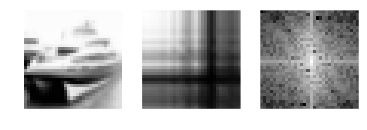

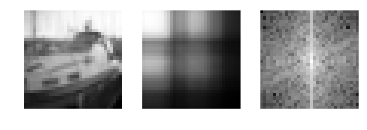

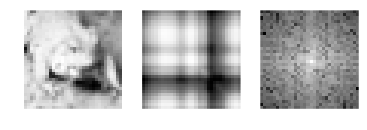

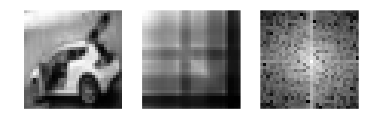

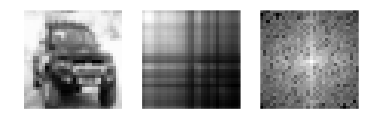

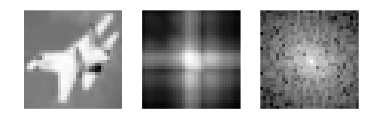

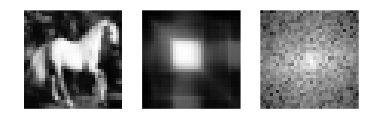

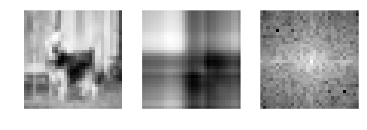

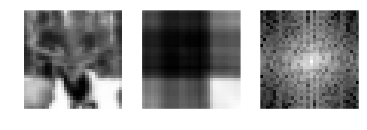

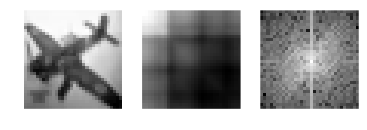

In [21]:
print "Groups with min accuracy (>0)"
print "First image is the original, second is the covariance matrix, and third is the real part of the FFT"
for i in indices_min_acc:
    print "Index: %d" % i
    visualize_augmented_images(augment_image(X_test_aug[i][0]))

Group with max accuracy
First image is the original, second is the covariance matrix, and third is the real part of the FFT
Index: 9976
Index: 9966
Index: 9959
Index: 9952
Index: 9946
Index: 9922
Index: 9920
Index: 9888
Index: 9884
Index: 9861


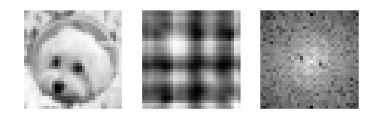

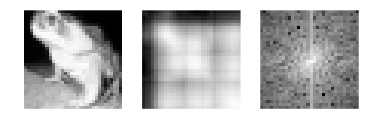

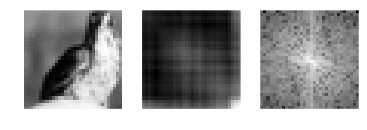

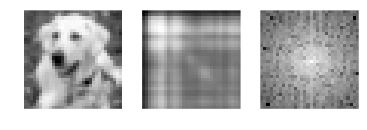

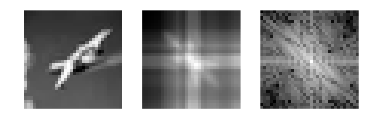

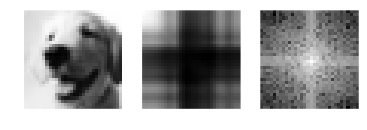

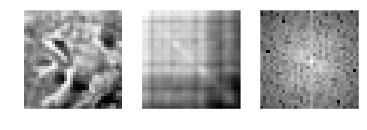

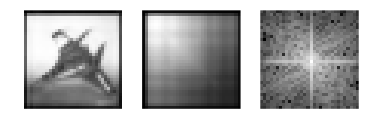

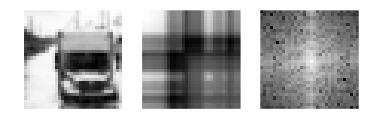

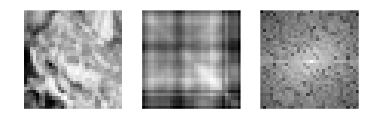

In [22]:
print "Group with max accuracy"
print "First image is the original, second is the covariance matrix, and third is the real part of the FFT"
for i in indices_max_acc:
    print "Index: %d" % i
    visualize_augmented_images(augment_image(X_test_aug[i][0]))